## 逻辑回归
代码修改并注释：廖永,广东工业大学硕士在读,如有错误或指正,请联系136884000@qq.com
代码运行环境：python3.7

在训练的初始阶段，我们将要构建一个逻辑回归模型来预测，某个学生是否被大学录取。设想你是大学相关部分的管理者，想通过申请学生两次测试的评分，来决定他们是否被录取。现在你拥有之前申请学生的可以用于训练逻辑回归的训练样本集。对于每一个训练样本，你有他们两次测试的评分和最后是被录取的结果。为了完成这个预测任务，我们准备构建一个可以基于两次测试评分来评估录取可能性的分类模型。

让我们从检查数据开始。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
data1=pd.read_csv('ex2data1.txt',names=['text1','text2', 'admitted'])
data1.head()

,text1,text2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


看下数据的信息

In [3]:
data1.describe()

,text1,text2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


让我们创建两个分数的散点图，并使用颜色编码来可视化，如果样本是正的（被接纳）或负的（未被接纳）。

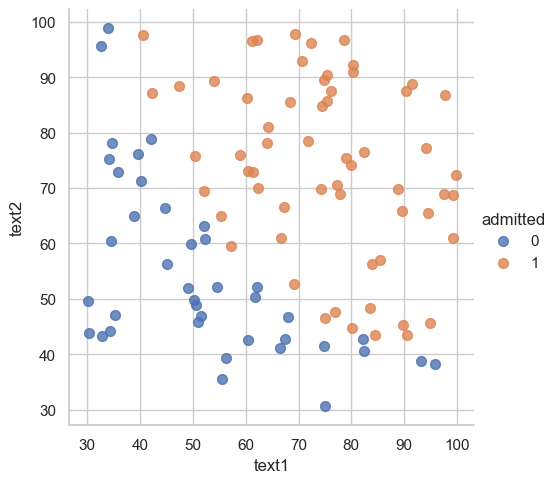

In [6]:
sns.set(context='notebook',style='whitegrid') 
sns.lmplot(x='text1',y='text2',data=data1,
            hue='admitted',   #定义数据子集的变量，绘制在图中
           #定义子图中每一格尺寸的高度，单位应为英寸
           fit_reg=False,  #不画拟合直线
           scatter_kws={"s": 50}  
           #附加的关键字参数以字典的形式传递给plt.scatter()函数
           #将plt.scatter()的参数s的值改为50，默认值为20 ，参数s代表散点的大小
          )
plt.show()

法2：

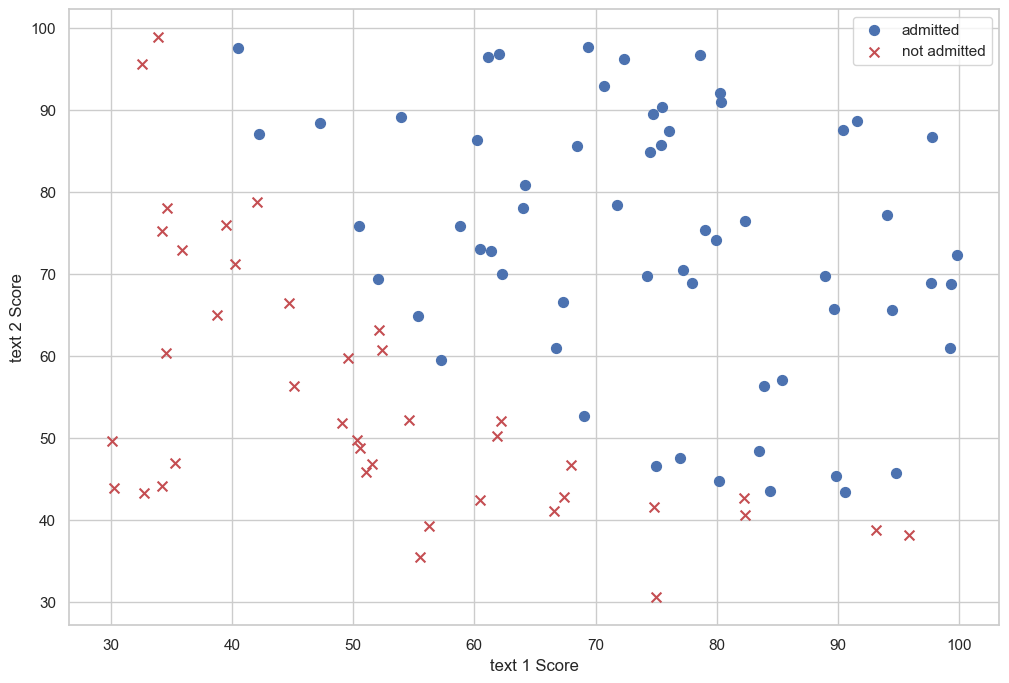

In [7]:
positive = data1[data1['admitted'].isin([1])] #isin（）为筛选函数，令positive为数据集中为1的数组
negative = data1[data1['admitted'].isin([0])] #isin（）为筛选函数，令positive为数据集中为0的数组

fig, ax = plt.subplots(figsize=(12,8))#以其他关键字参数**fig_kw来创建图
#figsize=(a,b):figsize 设置图形的大小,b为图形的宽,b为图形的高,单位为英寸
ax.scatter(positive['text1'], positive['text2'], s=50, c='b', marker='o', label='admitted')   
#x为Exam 1，y为Exam 2，散点大小s设置为50,颜色参数c为蓝色，散点形状参数marker为圈，以关键字参数**kwargs来设置标记参数labele是Admitted
ax.scatter(negative['text1'], negative['text2'], s=50, c='r', marker='x', label='not admitted')
#x为Exam 1，y为Exam 2，散点大小s设置为50,颜色参数c为红色，散点形状参数marker为叉，以关键字参数**kwargs来设置标记参数labele是Not Admitted
ax.legend()   #显示图例
ax.set_xlabel('text 1 Score')  #设置x轴变量
ax.set_ylabel('text 2 Score')   #设置y轴变量
plt.show()

看起来在两类间，有一个清晰的决策边界。现在我们需要实现逻辑回归，那样就可以训练一个模型来预测结果。方程实现在下面的代码示例在"exercises" 文件夹的 "ex2.pdf" 中。

In [11]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并
    return data.iloc[:, :-1]  # 这个操作返回 ndarray,不是矩阵  将数据为dataframe的形式转化成数组形式


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放

In [12]:
X = get_X(data1)
print(X.shape) #获取X的行数和列数

y = get_y(data1)
print(y.shape) #获取X的行数和列数

(100, 3)
(100,)


X为100行3列，y为100行 的数据

# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [13]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

让我们做一个快速的检查，来确保它可以工作。

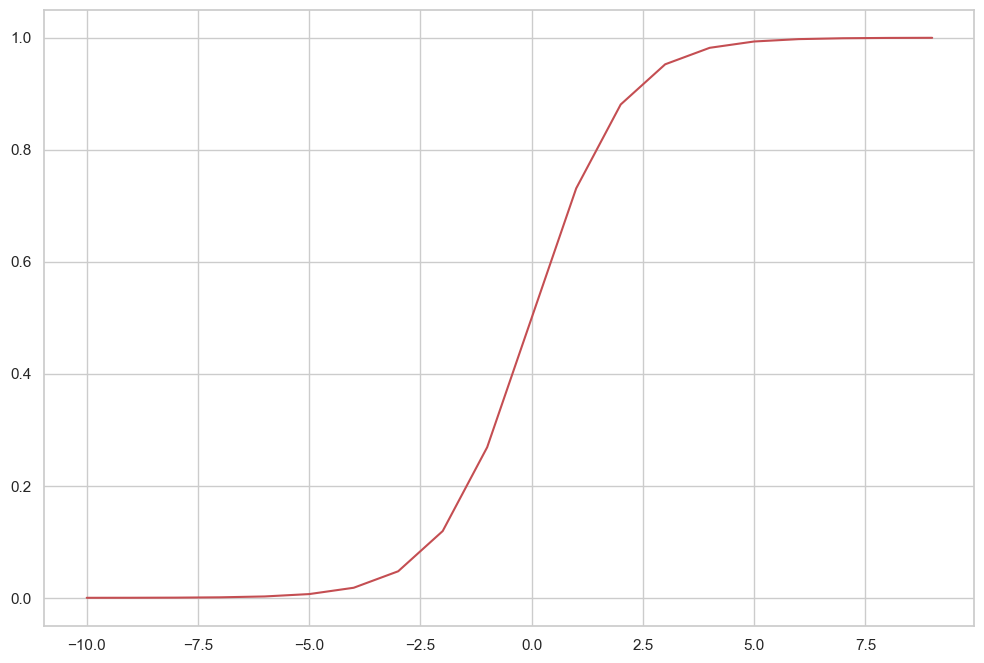

In [14]:
nums = np.arange(-10, 10, step=1)  #以-10为起点，10为终点，步长为1的列表
fig, ax = plt.subplots(figsize=(12,8))#以其他关键字参数**fig_kw来创建图
#figsize=(a,b):figsize 设置图形的大小,b为图形的宽,b为图形的高,单位为英寸
ax.plot(nums, sigmoid(nums), 'r')   
plt.show()

棒极了！现在，我们需要编写代价函数来评估结果。
代价函数：
$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$

In [15]:
def cost(theta, X, y):
    theta=np.matrix(theta) #将theta转换为矩阵
    X=np.matrix(X) #将X转换为矩阵
    y=np.matrix(y) #将y转换为矩阵
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))  #公式第一项  np.multiply为数组，矩阵相乘的函数
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))  #公式第二项
    return np.sum(first - second) / (len(X))

现在，我们要做一些设置，和我们在练习1在线性回归的练习很相似。

In [16]:
# add a ones column - this makes the matrix multiplication work out easier
data1.insert(0, 'Ones', 1) #在第0列插入表头为“ONE”的列，数值为1

# set X (training data) and y (target variable)
cols = data1.shape[1] #获取表格df的列数
X = data1.iloc[:,0:cols-1] #除最后一列外，取其他列的所有行，即X为O和人口组成的列表
y = data1.iloc[:,cols-1:cols] #取最后一列的所有行，即y为利润

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values) #将X的各个值转换为数组
y = np.array(y.values) #将y的各个值转换为数组
theta = np.zeros(3) #初始化theta数组为(0,0,0)

让我们来检查矩阵的维度来确保一切良好

In [17]:
X.shape,theta.shape,y.shape

((100, 3), (3,), (100, 1))

让我们计算初始化参数的代价函数(theta为0)。

In [18]:
cost(theta, X, y)

0.6931471805599453

看起来不错，接下来，我们需要一个函数来计算我们的训练数据、标签和一些参数thata的梯度。

# gradient descent(梯度下降)
* 这是批量梯度下降（batch gradient descent）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [19]:
def gradient(theta, X, y):
    theta=np.matrix(theta) #将theta转换为矩阵
    X=np.matrix(X) #将X转换为矩阵
    y=np.matrix(y) #将y转换为矩阵
    
    temp=np.matrix(np.zeros(theta.shape)) #np.zeros(theta.shape)=[0.,0.],然后将temp变为矩阵[0.,0.]
    parameters= int(theta.ravel().shape[1])  
    #theta.ravel()：将多维数组theta降为一维，.shape[1]是统计这个一维数组有多少个元素
    #parameters表示参数
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i]) #将误差与训练数据相乘，
        grad[i] = np.sum(term) / len(X)
    
    return grad

注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算一个梯度步长。在练习中，一个称为“fminunc”的Octave函数是用来优化函数来计算成本和梯度参数。由于我们使用Python，我们可以用SciPy的“optimize”命名空间来做同样的事情。

我们看看用我们的数据和初始参数为0的梯度下降法的结果。

In [20]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

现在可以用SciPy's truncated newton（TNC）实现寻找最优参数。

In [21]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y)) 
result  

(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)

返回值说明：（ 数组:返回的优化问题目标值,nfeval:整数,function evaluations的数目， rc）
              #在进行优化的时候,每当目标优化函数被调用一次,就算一个function evaluation.         
              在一次迭代过程中会有多次function evaluation.这个参数不等同于迭代次数，而往往大于迭代次数.
              

让我们看看在这个结论下代价函数计算结果是什么个样子~

In [22]:
cost(result[0], X, y)  #result[0]:取数组result中的第一个元素

0.20349770158947458

### 预测和验证

In [23]:
def predictA(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)  #.astype():将大于0.5的函数值转化为整型，即取整。

In [24]:
final_theta1 = result[0]  #取最优参数中优化问题目标值数组x
y_pred = predictA(X, final_theta1)

print(classification_report(y, y_pred))  #classification_report函数用于显示主要分类指标的文本报告

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



其中列表左边的一列为分类的标签名，右边support列为每个标签的出现次数．avg / total行为各列的均值（support列为总和）． 
precision recall f1-score三列分别为各个类别的精确度/召回率及 F1 F1值．

***
接下来，我们需要编写一个函数，用我们所学的参数theta来为数据集X输出预测。然后，我们可以使用这个函数来给我们的分类器的训练精度打分。
逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 
当${{h}_{\theta }}$大于等于0.5时，预测 y=1

当${{h}_{\theta }}$小于0.5时，预测 y=0 。

In [25]:
def predictB(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]  #大于0.5的数取值为1，小于0.5的为0

In [26]:
theta_min = np.matrix(result[0]) #将最优化最优参数中优化问题目标值数组x转化为矩阵
predictions = predictB(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
#predictions为预测值,y为实际值.zip为打包对象函数，将(predictions, y)打包成元组，并赋值为（a,b），然后判断正确的则返回1，判断错误的返回0
accuracy = (sum(map(int, correct)) % len(correct))
# map(int, correct):将crrect列表内容的类型映射成int型，原来应该布尔型.sum为求和函数，%为求模运算，计算除法的余数。
#实际是求1占数据总数的比例
print ('accuracy = {0}%'.format(accuracy))  #format为格式化字符串的函数,{0}为设置指定位置.

accuracy = 89%


我们的逻辑回归分类器预测正确，如果一个学生被录取或没有录取，达到89%的精确度。不坏！记住，这是训练集的准确性。我们没有保持住了设置或使用交叉验证得到的真实逼近，所以这个数字有可能高于其真实值（这个话题将在以后说明）。

# 寻找决策边界
http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier
> $X \times \theta = 0$  (this is the line)

In [27]:
print(result[0]) # this is final theta

[-25.16131863   0.20623159   0.20147149]


In [28]:
coef = -(result[0]/ ((result[0])[2])) #将result[0]中的每一个数除以result[0]中的第三个元素，然后取相反值
print(coef)

x = np.arange(130, step=0.1) #默认起点为0，终点为130，步长为0.1的数组
y = coef[0] + coef[1]*x

[124.88774019  -1.02362668  -1.        ]


你知道x和y的截获量都是125左右

In [29]:
data1.describe()

,Ones,text1,text2,admitted
count,100.0,100.000000,100.000000,100.000000
mean,1.0,65.644274,66.221998,0.600000
std,0.0,19.458222,18.582783,0.492366
min,1.0,30.058822,30.603263,0.000000
25%,1.0,50.919511,48.179205,0.000000
50%,1.0,67.032988,67.682381,1.000000
75%,1.0,80.212529,79.360605,1.000000
max,1.0,99.827858,98.869436,1.000000


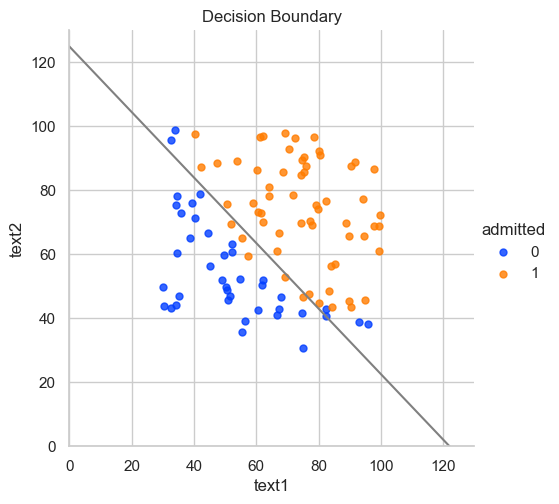

In [32]:
sns.set(context='notebook',style='whitegrid',palette='bright')
sns.lmplot(x='text1',y='text2',data=data1, #x为text1,y为text2，数据集为data1
           hue='admitted', #定义数据子集的变量，绘制在图中
            #定义子图中每一格尺寸的高度，单位应为英寸
           fit_reg=False,   #不拟合直线
           scatter_kws={"s": 25}  #设置散点的大小为25
          )
plt.plot(x, y, 'grey') #plot为画图函数，plot(x变量，y变量，‘线条颜色和；类型’)，设置线条颜色为灰色
plt.xlim(0, 130)  #设置x轴的范围
plt.ylim(0, 130) #设置y轴的范围
plt.title('Decision Boundary')  #设置标题
plt.show()

## 正则化逻辑回归

在训练的第二部分，我们将要通过加入正则项提升逻辑回归算法。如果你对正则化有点眼生，或者喜欢这一节的方程的背景，请参考在"exercises"文件夹中的"ex2.pdf"。简而言之，正则化是成本函数中的一个术语，它使算法更倾向于“更简单”的模型（在这种情况下，模型将更小的系数）。这个理论助于减少过拟合，提高模型的泛化能力。这样，我们开始吧。

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

和第一部分很像，从数据可视化开始吧！

In [33]:
data2=pd.read_csv('ex2data2.txt',names=['text1','text2', 'accepted'])
data2.head()

,text1,text2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


看下数据的信息

In [34]:
data2.describe()

,text1,text2,accepted
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646563,1.000000
max,1.070900,1.108900,1.000000


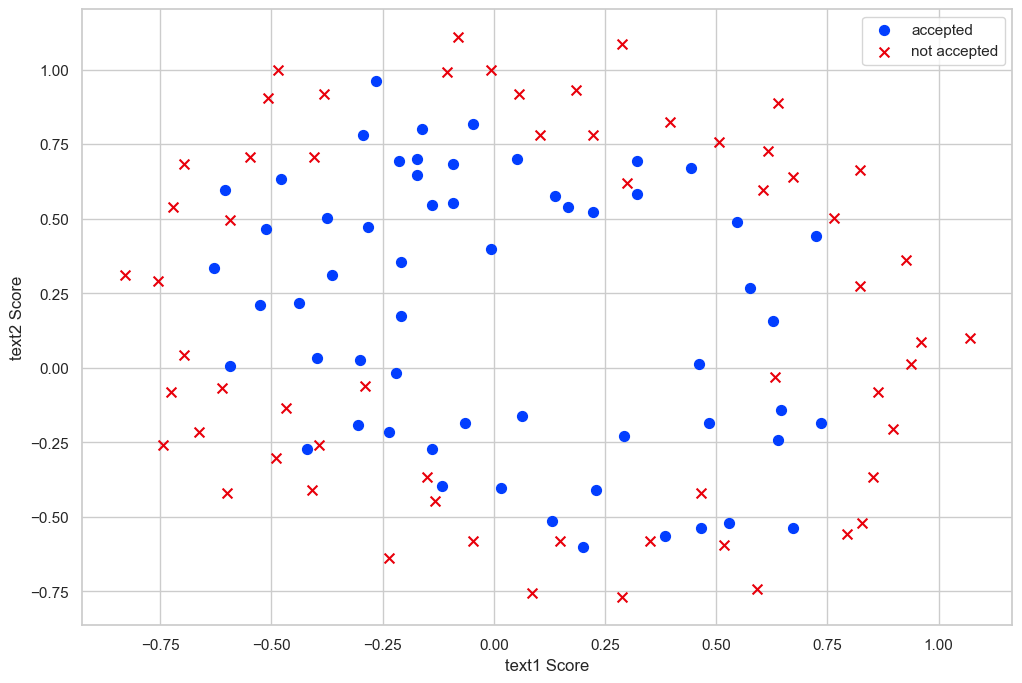

In [35]:
positive = data2[data2['accepted'].isin([1])] #isin（）为筛选函数，令positive为数据集中为1的数组
negative = data2[data2['accepted'].isin([0])] #isin（）为筛选函数，令positive为数据集中为0的数组

fig, ax = plt.subplots(figsize=(12,8))#以其他关键字参数**fig_kw来创建图
#figsize=(a,b):figsize 设置图形的大小,b为图形的宽,b为图形的高,单位为英寸
ax.scatter(positive['text1'], positive['text2'], s=50, c='b', marker='o', label='accepted')   
#x为Exam 1，y为Exam 2，散点大小s设置为50,颜色参数c为蓝色，散点形状参数marker为圈，以关键字参数**kwargs来设置标记参数labele是Admitted
ax.scatter(negative['text1'], negative['text2'], s=50, c='r', marker='x', label='not accepted')
#x为Exam 1，y为Exam 2，散点大小s设置为50,颜色参数c为红色，散点形状参数marker为叉，以关键字参数**kwargs来设置标记参数labele是Not Admitted
ax.legend()   #显示图例
ax.set_xlabel('text1 Score')  #设置x轴变量
ax.set_ylabel('text2 Score')   #设置y轴变量
plt.show()

哇，这个数据看起来可比前一次的复杂得多。特别地，你会注意到其中没有线性决策界限，来良好的分开两类数据。一个方法是用像逻辑回归这样的线性技术来构造从原始特征的多项式中得到的特征。让我们通过创建一组多项式特征入手吧。

In [36]:
degree = 5
x1 = data2['text1']
x2 = data2['text2']

data2.insert(3, 'Ones', 1) #在第4列插入标题为One,各行值为1的列

for i in range(1, degree):
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)
        #np.power(A,B)   ## 对A中的每个元素求B次方


data2.drop('text1', axis=1, inplace=True)#删除表头为Test 1的列，axis=1表示默认删除行或列，inplace=True表示原数组被data2替换.
data2.drop('text2', axis=1, inplace=True)#删除表头为Test 2的列，axis=1表示默认删除行或列，inplace=True表示原数组被data2替换.

data2.head()

,accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


现在，我们需要修改第1部分的成本和梯度函数，包括正则化项。首先是成本函数：

# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [37]:
def costreg(theta,X,y,learningRate):
    theta=np.matrix(theta)
    X=np.matrix(X)
    y=np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second=np.multiply((1-y),np.log(1-sigmoid(X*theta.T)))
    reg=(learningRate/(2*len(x))*np.sum(np.power(theta[:,1:theta.shape[1]],2)))
    return np.sum(first - second) / len(X) + reg

请注意等式中的"reg" 项。还注意到另外的一个“学习率”参数。这是一种超参数，用来控制正则化项。现在我们需要添加正则化梯度函数：

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$

In [38]:
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    #theta.ravel():将多维数组转换为一维数组，并不会产生源数据的副本. shape[1]:获取列数
    grad = np.zeros(parameters) #创建零数组
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad            

就像在第一部分中做的一样，初始化变量。

In [39]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]  #获取data2的列数
X2 = data2.iloc[:,1:cols] #取所有列每一行的数据
y2 = data2.iloc[:,0:1] #取第一和第二列每一行的数据

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values) #将数值转换为数组
y2 = np.array(y2.values)
theta2 = np.zeros(11) #创建长度为11的零数组

让我们初始学习率到一个合理值。，果有必要的话（即如果惩罚太强或不够强）,我们可以之后再折腾这个。

In [40]:
learningRate=1

现在，让我们尝试调用新的默认为0的theta的正则化函数，以确保计算工作正常。

In [41]:
costreg(theta2, X2, y2, learningRate)

0.6931471805599454

In [42]:
gradientReg(theta2, X2, y2, learningRate)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18500\967574002.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])


array([0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
       0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
       0.00309594])

现在我们可以使用和第一部分相同的优化函数来计算优化后的结果。

In [43]:
result2 = opt.fmin_tnc(func=costreg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
result2

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18500\967574002.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])


(array([ 0.53070798,  0.29159049, -1.6104325 , -0.58237423,  0.01615716,
        -0.21260328, -0.40181821, -1.36892012,  0.02274358, -0.94999674,
         0.03389808]),
 50,
 4)

返回值说明：（ 数组:返回的优化问题目标值,nfeval:整数,function evaluations的数目， rc）
              #在进行优化的时候,每当目标优化函数被调用一次,就算一个function evaluation.         
              在一次迭代过程中会有多次function evaluation.这个参数不等同于迭代次数，而往往大于迭代次数.

最后，我们可以使用第1部分中的预测函数来查看我们的方案在训练数据上的准确度。

In [44]:
theta_min = np.matrix(result2[0])
predictions = predictB(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
#predictions为预测值,y为实际值.zip为打包对象函数，将(predictions, y)打包成元组，并赋值为（a,b），然后判断正确的则返回1，判断错误的返回0
accuracy = (sum(map(int, correct)) % len(correct))
# map(int, correct):将crrect列表内容的类型映射成int型，原来应该布尔型.sum为求和函数，%为求模运算，计算除法的余数。
#实际是求1占数据总数的比例
print ('accuracy = {0}%'.format(accuracy))

accuracy = 78%


虽然我们实现了这些算法，值得注意的是，我们还可以使用高级Python库像scikit-learn来解决这个问题。

In [45]:
from sklearn import linear_model#调用sklearn的线性回归包
model = linear_model.LogisticRegression(penalty='l2', C=1.0)
model.fit(X2, y2.ravel())

LogisticRegression()

In [46]:
model.score(X2, y2)

0.6610169491525424

这个准确度和我们刚刚实现的差了好多，不过请记住这个结果可以使用默认参数下计算的结果。我们可能需要做一些参数的调整来获得和我们之前结果相同的精确度。